<a href="https://colab.research.google.com/github/mamfyou/BookManage-Trial-/blob/master/assignment_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fine-Tuning mBERT and Exploring Token Generation with GPT‑2

In [ ]:

# If running on a fresh environment, install required packages.
# Uncomment the next line if you need to install the libraries.
!pip install -U datasets transformers[sentencepiece] matplotlib --quiet

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import torch
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 92.3 MB/s eta 0:00:00



## 1  Fine‑tuning mBERT for sentiment classification

### Load the Digikala sentiment dataset
The `ParsiAI/digikala-sentiment-analysis` dataset is hosted on Hugging Face and can be loaded via the `datasets` library.  Each example includes a Farsi product review (`Text`), a numeric `Score` from 0 to 100, and a `Suggestion` label (1=positive, 2=negative, 3=neutral)【901530432670351†L54-L96】.  Below we download the dataset and map the `Suggestion` labels to integers starting at 0, because PyTorch models expect labels in `[0, num_labels‑1]`.


In [ ]:

# Load the dataset
raw_datasets = load_dataset('ParsiAI/digikala-sentiment-analysis')

# Map `Suggestion` to a zero‑based label: 1→0 (positive), 2→1 (negative), 3→2 (neutral)
label_mapping = {1: 0, 2: 1, 3: 2}

def preprocess_labels(example):
    example['label'] = label_mapping.get(example['Suggestion'], 0)
    return example

raw_datasets = raw_datasets.map(preprocess_labels)

num_labels = 3
raw_datasets


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/436 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/995k [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/228k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/222k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2282 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/489 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/490 [00:00<?, ? examples/s]

Map:   0%|          | 0/2282 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'label'],
        num_rows: 2282
    })
    validation: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'label'],
        num_rows: 489
    })
    test: Dataset({
        features: ['Text', 'Score', 'Suggestion', 'label'],
        num_rows: 490
    })
})


### Tokenize the text
We use the tokenizer associated with the multilingual BERT model to convert text into token IDs.  The `DataCollatorWithPadding` dynamically pads sequences within a batch to the maximum length in that batch, which simplifies batching.


In [ ]:

# Initialize tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['Text'], truncation=True)

# Tokenize the datasets
encoded_datasets = raw_datasets.map(tokenize_function, batched=True)

# Remove columns not needed by the model
encoded_datasets = encoded_datasets.remove_columns(['Text', 'Score', 'Suggestion'])
encoded_datasets = encoded_datasets.rename_column('label', 'labels')

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

encoded_datasets.set_format('torch')
encoded_datasets


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/2282 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2282
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 489
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 490
    })
})


### Create and fine‑tune the model
We load the `bert-base-multilingual-cased` model for sequence classification with three labels.  The `Trainer` API handles training and evaluation.  To keep the demonstration lightweight, the training arguments specify a small number of epochs and a modest batch size; you can adjust these parameters for better performance.


In [ ]:

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Training arguments
train_args = TrainingArguments(
    output_dir='mbart-sentiment-results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01
)

# Define metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Create Trainer
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=encoded_datasets['train'],
    eval_dataset=encoded_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model (this may take several minutes)
trainer.train()

# Evaluate on the validation and test sets
val_metrics = trainer.evaluate(encoded_datasets['validation'])
test_metrics = trainer.evaluate(encoded_datasets['test'])
val_metrics, test_metrics


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2050824881.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mamf20021381 (mamf20021381-my-company) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.733900


({'eval_loss': 0.6577279567718506,
  'eval_accuracy': 0.754601226993865,
  'eval_f1': 0.7029702140453389,
  'eval_runtime': 8.7335,
  'eval_samples_per_second': 55.991,
  'eval_steps_per_second': 3.55,
  'epoch': 2.0},
 {'eval_loss': 0.697381854057312,
  'eval_accuracy': 0.7224489795918367,
  'eval_f1': 0.6568575371376264,
  'eval_runtime': 8.3684,
  'eval_samples_per_second': 58.554,
  'eval_steps_per_second': 3.704,
  'epoch': 2.0})


### Compare base vs. fine‑tuned model on sample sentences
Below we define a few real reviews from the dataset【901530432670351†L96-L115】【901530432670351†L121-L132】 and run both the base mBERT model (with randomly initialized classification head) and the fine‑tuned model on these sentences.  For the base model we load `bert-base-multilingual-cased` with the same classification head but without training.


In [ ]:
# Sample Farsi sentences from the dataset
sample_texts = [
    "قیمت مناسب ولی صدا خیلی زیاد",  # likely negative (label 2→1)
    "دو سالی مشه که از دیجی کالا خریدم خیلی خوبه قدرتش زیاده",  # positive
    "سلام دوستای عزیزم من دیروز این محصول رو خریداری کردم واقعاً خوبه",  # positive
    "اگه هدفون ارزون میخوایید بخرید",  # probably neutral or negative
    "من 1 سال خریدمش و از همه چیزش راضی ام"  # positive
]

from torch.nn import functional as F
import torch

# Function to get predictions given a model
def predict_sentences(model, texts, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.cpu()
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
    return preds.numpy(), probs.numpy()

# Load base model with random classification head
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Predictions from base and fine‑tuned models
base_preds, base_probs = predict_sentences(base_model, sample_texts)
ft_preds, ft_probs = predict_sentences(model, sample_texts)

# Map integer labels back to sentiment names
id2label = {0: 'positive', 1: 'negative', 2: 'neutral'}

import pandas as pd
results = []
for i, text in enumerate(sample_texts):
    results.append({
        'text': text,
        'base_pred': id2label[base_preds[i]],
        'base_prob': base_probs[i][base_preds[i]],
        'fine_tuned_pred': id2label[ft_preds[i]],
        'fine_tuned_prob': ft_probs[i][ft_preds[i]]
    })

pd.DataFrame(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,text,base_pred,base_prob,fine_tuned_pred,fine_tuned_prob
0,قیمت مناسب ولی صدا خیلی زیاد,neutral,0.362978,positive,0.704288
1,دو سالی مشه که از دیجی کالا خریدم خیلی خوبه قد...,neutral,0.372574,positive,0.887479
2,سلام دوستای عزیزم من دیروز این محصول رو خریدار...,neutral,0.374292,positive,0.909025
3,اگه هدفون ارزون میخوایید بخرید,neutral,0.358876,neutral,0.480020
4,من 1 سال خریدمش و از همه چیزش راضی ام,neutral,0.373967,positive,0.928220



## 2  Token‑by‑token generation with GPT‑2

Language models produce a probability distribution over the next token given the context.  We explore this distribution for a simple English prompt using a GPT‑2 model.  At each step we can either pick the most‑probable token (greedy decoding) or sample randomly from the top few candidates.  Sampling from the top \(k\) tokens introduces diversity into the generated text, whereas greedy decoding often yields the same generic continuation.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

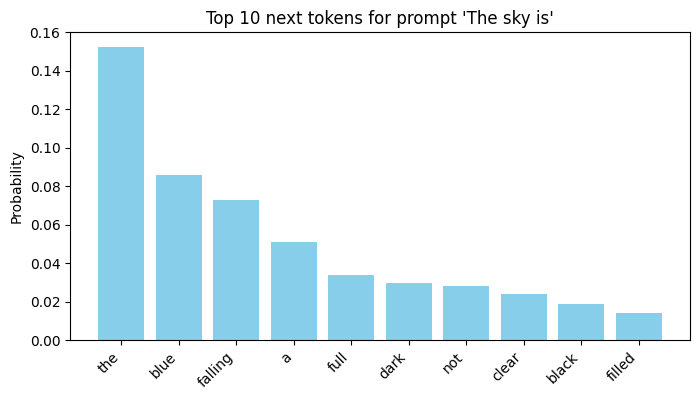

Greedy generation: The sky is the limit.

The sky is the limit.

The sky is the limit.

The sky is the limit.

The
Random‑sampling generation: The sky is the limit, but the sky is always the limit. And that's why we're here.

The sky is the limit, but the sky


In [ ]:

# Load GPT‑2 tokenizer and model
lm_name = 'gpt2'
lm_tokenizer = AutoTokenizer.from_pretrained(lm_name)
lm_model = AutoModelForCausalLM.from_pretrained(lm_name)

# Ensure tokenizer knows the special tokens
lm_tokenizer.pad_token = lm_tokenizer.eos_token

from typing import List, Tuple

# Function to compute top k tokens and probabilities
def top_k_tokens(logits, k=10) -> List[Tuple[str, float]]:
    probs = torch.softmax(logits, dim=-1)
    topk = torch.topk(probs, k)
    token_ids = topk.indices[0].tolist()
    token_probs = topk.values[0].tolist()
    tokens = [lm_tokenizer.decode([i]).strip() for i in token_ids]
    return list(zip(tokens, token_probs))

import matplotlib.pyplot as plt

def plot_top_tokens(tokens_probs: List[Tuple[str, float]], title: str):
    tokens, probs = zip(*tokens_probs)
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(tokens)), probs, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.ylabel('Probability')
    plt.title(title)
    plt.show()

# Greedy and random sampling functions
def generate_text(prompt: str, strategy: str = 'greedy', max_new_tokens: int = 20, top_n: int = 3) -> str:
    # Generate text token by token using the specified strategy.
    # strategy: 'greedy' or 'random'
    # top_n: number of top tokens to consider for random sampling
    input_ids = lm_tokenizer.encode(prompt, return_tensors='pt')
    generated = input_ids.clone()
    for _ in range(max_new_tokens):
        outputs = lm_model(generated)
        next_token_logits = outputs.logits[:, -1, :]
        probs = torch.softmax(next_token_logits, dim=-1)
        if strategy == 'greedy':
            next_token = torch.argmax(probs, dim=-1)
        else:
            top_probs, top_indices = torch.topk(probs, top_n)
            top_probs = top_probs.squeeze()
            top_indices = top_indices.squeeze()
            top_probs = top_probs / torch.sum(top_probs)
            choice = np.random.choice(top_indices.detach().numpy(), p=top_probs.detach().numpy())
            next_token = torch.tensor([choice])
        generated = torch.cat([generated, next_token.unsqueeze(0)], dim=1)
        if next_token.item() == lm_tokenizer.eos_token_id:
            break
    return lm_tokenizer.decode(generated[0], skip_special_tokens=True)

# Example: visualize the next-token distribution
prompt = "The sky is"
input_ids = lm_tokenizer.encode(prompt, return_tensors='pt')
with torch.no_grad():
    outputs = lm_model(input_ids)
    next_logits = outputs.logits[:, -1, :]

# Compute top 10 tokens
tokens_probs = top_k_tokens(next_logits, k=10)
plot_top_tokens(tokens_probs, title=f"Top 10 next tokens for prompt '{prompt}'")

# Generate text greedily
greedy_text = generate_text(prompt, strategy='greedy', max_new_tokens=30)
print('Greedy generation:', greedy_text)

# Generate text with random sampling from the top 3 tokens
random_text = generate_text(prompt, strategy='random', max_new_tokens=30, top_n=3)
print('Random‑sampling generation:', random_text)
